# **Employee Retention Prediction**

In [73]:
# Library imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

**Load and explore data**

In [74]:
# create a function to load and preprocess the data.
def load_and_preprocess_data(file_path):
    # Load the data
    df = pd.read_csv(file_path)

    # Handle missing values
    df['DateofTermination'].fillna('', inplace=True)

    # Convert date columns to datetime
    date_columns = ['DOB', 'DateofHire', 'DateofTermination', 'LastPerformanceReview_Date']
    for col in date_columns:
        df[col] = pd.to_datetime(df[col])

    return df

**Exploratory Data Analysis**

In [75]:
# Create function for EDA
def perform_eda(df):

    # Visualize turnover rate by department
    turnover_by_dept = df.groupby('Department')['Termd'].mean().sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    turnover_by_dept.plot(kind='bar')
    plt.title('Turnover Rate by Department')
    plt.ylabel('Turnover Rate')
    plt.tight_layout()
    plt.show()

**Feature Engineering / Creating new columns**

In [76]:
# Create function for Feature Engineering
def engineer_features(df):
    # Create salary to performance ratio and numeric value column for PerformanceScore
    performance_map = {'PIP': 1, 'Needs Improvement': 2, 'Fully Meets': 3, 'Exceeds': 4}
    df['PerformanceScore_Numeric'] = df['PerformanceScore'].map(performance_map)
    df['SalaryToPerformanceRatio'] = df['Salary'] / df['PerformanceScore_Numeric']

    return df

**Model Development and Evaluation**

In [77]:
# Create function to select features and normalize/encode data
def prepare_data_for_model(df):
    # Select features
    features = ['Age', 'Salary', 'Tenure', 'EngagementSurvey', 'EmpSatisfaction',
                'PerformanceScore_Numeric', 'DaysLateLast30', 'Absences',
                'SalaryToPerformanceRatio', 'YearsSinceLastReview']
    categorical_features = ['Department', 'MaritalDesc', 'CitizenDesc', 'RaceDesc', 'RecruitmentSource']

    X = df[features + categorical_features]
    y = df['Termd']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create preprocessing steps
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, features),
            ('cat', categorical_transformer, categorical_features)
        ])

    return preprocessor, X_train, X_test, y_train, y_test

In [78]:
# Create a function to fit and evaluate selected models
def create_evaluate_models(preprocessor, X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'SVM': SVC(random_state=42)
    }

    results = {}

    for name, model in models.items():
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', model)])

        # Perform cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')

        # Fit the model and make predictions
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Store results
        results[name] = {
            'cv_scores': cv_scores,
            'test_report': classification_report(y_test, y_pred, output_dict=True),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'model': pipeline
        }

    return results

**Interpretation and Insights / Feature Importance**

In [79]:
# 6. Interpretation and Insights
def interpret_model(model, X):
    feature_importance = model.named_steps['classifier'].feature_importances_
    feature_names = (model.named_steps['preprocessor']
                     .named_transformers_['num'].get_feature_names_out().tolist() +
                     model.named_steps['preprocessor']
                     .named_transformers_['cat'].get_feature_names_out().tolist())

    importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
    importance_df = importance_df.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance_df.head(10))
    plt.title('Top 10 Feature Importances')
    plt.tight_layout()
    plt.show()

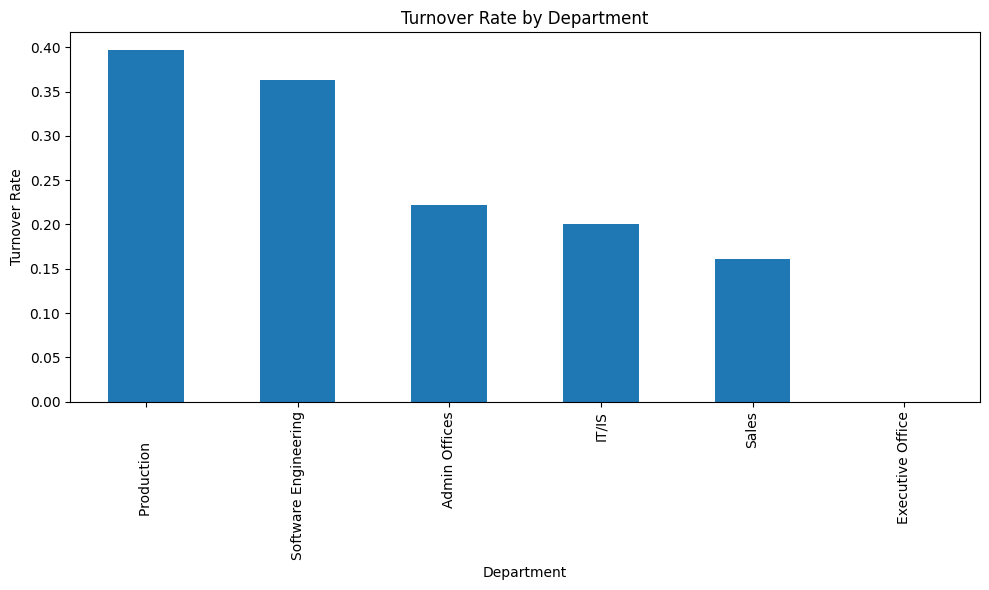


Model: Logistic Regression
Cross-validation F1 scores: [0.96774194 0.97142857 0.96969697 1.         0.96774194]
Mean CV F1 score: 0.975
Test F1 score: 0.951


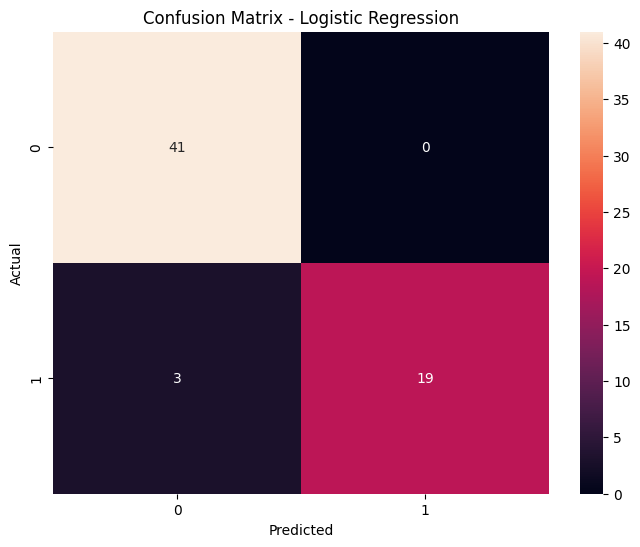


Model: Random Forest
Cross-validation F1 scores: [0.96774194 0.96969697 0.96969697 1.         1.        ]
Mean CV F1 score: 0.981
Test F1 score: 0.935


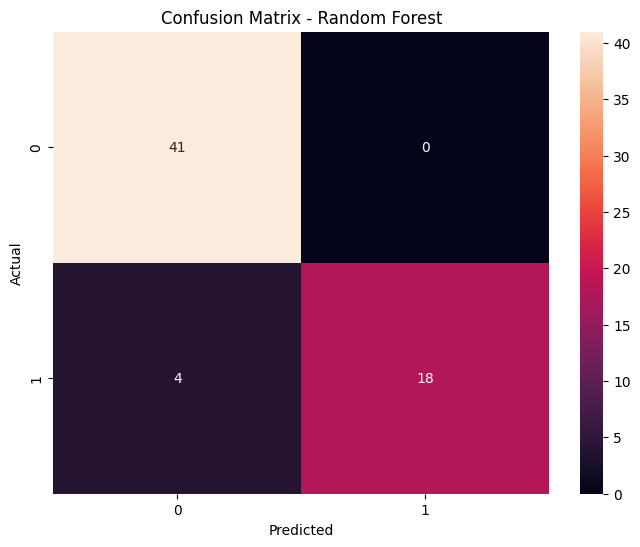


Model: Gradient Boosting
Cross-validation F1 scores: [0.96774194 1.         1.         1.         1.        ]
Mean CV F1 score: 0.994
Test F1 score: 0.935


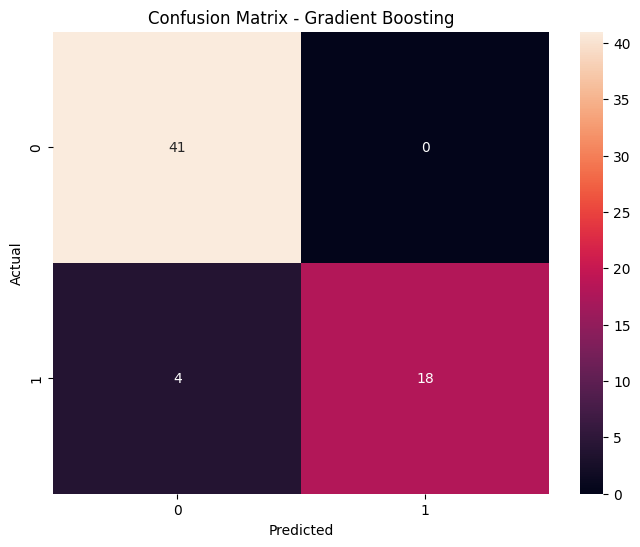


Model: SVM
Cross-validation F1 scores: [0.96774194 0.94117647 0.96969697 1.         0.89655172]
Mean CV F1 score: 0.955
Test F1 score: 0.918


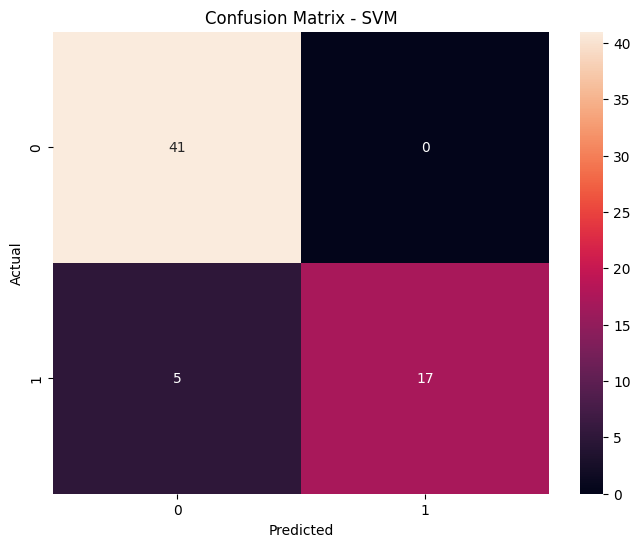

In [80]:
# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    df = load_and_preprocess_data('/content/HRDataset_cleaned.csv')

    # Perform EDA
    perform_eda(df)

    # Engineer features
    df = engineer_features(df)

    # Prepare data for modeling
    preprocessor, X_train, X_test, y_train, y_test = prepare_data_for_model(df)

    # Train and evaluate models
    results = create_evaluate_models(preprocessor, X_train, X_test, y_train, y_test)

    # Print results
    for name, result in results.items():
        print(f"\nModel: {name}")
        print(f"Cross-validation F1 scores: {result['cv_scores']}")
        print(f"Mean CV F1 score: {result['cv_scores'].mean():.3f}")
        print(f"Test F1 score: {result['test_report']['weighted avg']['f1-score']:.3f}")

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(result['confusion_matrix'], annot=True, fmt='d')
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


In [81]:
# Interpret the best model
# best_model = results['Logistic Regression']['model']
# interpret_model(best_model, X_train)